<a href="https://colab.research.google.com/github/GabyDs/FirearmShotDetectionSystem/blob/main/FirearmShotDetectionSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [2]:
import os

import numpy as np
import pandas as pd

import scipy as sp
from scipy import signal

import matplotlib.pyplot as plt

import librosa, librosa.display
import IPython.display as ipd

import sklearn
from sklearn.model_selection import train_test_split

import tensorflow
import tensorflow_hub as hub
from tensorflow import keras

# Dataset

In [ ]:
!wget -c --no-check-certificate "https://drive.google.com/u/0/uc?id=1AFySnqxTCFhdeZZ02XpbUStgJyZoAirw&confirm=t" -O audios.zip

In [ ]:
!wget -c --no-check-certificate "https://drive.google.com/u/0/uc?id=13fPmh97a4_UrmPkktJ-g8_-uEy2KhrCm&confirm=t" -O audios_completos.zip

In [ ]:
!unzip audios.zip

In [ ]:
!unzip audios_completos.zip

In [7]:
os.remove('/content/Audios_disparos_selva/train/fondo/603EFD8C.WAV')
os.remove('/content/Audios_disparos_selva/train/fondo/603EEE5A.WAV')

# Explore Dataset

## Auxiliaries functions

In [27]:
SAMPLE_RATE = 8000
FRAME_LENGTH = 512
HOP_LENGTH = FRAME_LENGTH//2
N_MELS = 40
N_MFCC = 13

In [10]:
def extract_fft(signal):
  signal_fft = sp.fft.fft(signal, FRAME_LENGTH)
  signal_mag = np.abs(signal_fft)

  return signal_fft, signal_mag

In [11]:
def extract_spectrogram(signal):
  return np.abs(librosa.stft(signal,
                             n_fft=FRAME_LENGTH,
                             hop_length=HOP_LENGTH))

In [12]:
def extract_mel_spectrogram(signal, sr):
  signal_mel_spectrogram = librosa.feature.melspectrogram(y=signal,
                                                          sr=sr,
                                                          n_fft=FRAME_LENGTH,
                                                          hop_length=HOP_LENGTH,
                                                          n_mels=N_MELS)

  signal_log_mel_spectrogram = librosa.power_to_db(signal_mel_spectrogram)

  return signal_log_mel_spectrogram

In [13]:
def extract_mfccs(signal, sr):
  mfccs = librosa.feature.mfcc(y=signal,
                               n_fft=FRAME_LENGTH,
                               hop_length=HOP_LENGTH,
                               n_mfcc=N_MFCC,
                               sr=sr)

  scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
  mfccs = scaler.fit_transform(mfccs)

  return mfccs[1:]

In [14]:
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

def extract_spectral_centroid(signal, sr):
    return librosa.feature.spectral_centroid(y=signal,
                                             sr=sr,
                                             n_fft=FRAME_LENGTH,
                                             hop_length=HOP_LENGTH)[0]

In [15]:
def plot_fft(signal, sr, audio_type=None):
  signal_fft, signal_mag = extract_fft(signal)

  frequency = np.linspace(0, sr, len(signal_fft))
  f_bins = FRAME_LENGTH//2 + 1

  plt.figure(figsize=(8, 4))
  plt.plot(frequency[:f_bins], signal_mag[:f_bins])

  plt.xlabel('Frequency [Hz]')
  plt.ylabel('Amplitude')
  plt.title(f'Frequency domain spectrum to {audio_type}')
  plt.show()

In [16]:
def plot_spectrogram(signal, y_axis='linear', audio_type=None):
  spectrogram = extract_spectrogram(signal)

  if y_axis == 'log':
    spectrogram = librosa.amplitude_to_db(spectrogram)

  plt.figure(figsize=(8, 4))
  librosa.display.specshow(spectrogram,
                           y_axis=y_axis,
                           x_axis='time')

  plt.title(f'Spectrogram to {audio_type}')
  plt.colorbar(format='%+2.f')
  plt.show()


In [17]:
def plot_mel_spectrogram(signal, sr, audio_type=None):
  mel_spectrogram = extract_mel_spectrogram(signal, sr)

  plt.figure(figsize=(8, 4))
  librosa.display.specshow(mel_spectrogram,
                           y_axis='mel',
                           x_axis='time')

  plt.title(f'Mel spectrogram to {audio_type}')
  plt.colorbar(format='%+2.f')
  plt.show()

In [18]:
def plot_mfcc(signal, sr, audio_type=None):
  mfccs = extract_mfccs(signal, sr)

  plt.figure(figsize=(8, 4))
  librosa.display.specshow(mfccs,
                         x_axis="time",
                         sr=sr)

  plt.title(f'Mel spectrogram to {audio_type}')
  plt.ylabel('Coefficients')
  plt.colorbar(format="%+2.f")
  plt.show()

In [19]:
def plot_spectral_centroid(signal, sr, audio_type=None):

    spectral_centroids = extract_spectral_centroid(signal, sr)

    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)

    plt.figure(figsize=(8, 4))
    librosa.display.waveshow(y=signal, sr=sr, color='b')

    plt.plot(t, normalize(spectral_centroids), color='r')
    plt.title(f'Spectral centroids to {audio_type}')
    plt.show()

## Load audios names

In [20]:
DATASET_PATH = './Audios_disparos_selva/train'
VAL_DATASET_PATH = './Audios_disparos_selva/val'

In [21]:
def load_dataset_names(dataset_path: str) -> dict:
    DATASET = {
        'audio_name': [],
        'labels': []
    }

    for i, (dirpath, _, filenames) in enumerate(os.walk(dataset_path)):

        if dirpath != dataset_path:

            for f in filenames:
                file_path = os.path.join(dirpath, f)
                DATASET['audio_name'].append(file_path)
                DATASET['labels'].append(i-1)

    return DATASET

In [22]:
DATASET = pd.DataFrame(load_dataset_names(DATASET_PATH))
VAL_DATASET = pd.DataFrame(load_dataset_names(VAL_DATASET_PATH))

In [23]:
DATASET

,audio_name,labels
0,./Audios_disparos_selva/train/fondo/6025B858.WAV,0
1,./Audios_disparos_selva/train/fondo/5C8AD07B.WAV,0
2,./Audios_disparos_selva/train/fondo/5C8873AB.WAV,0
3,./Audios_disparos_selva/train/fondo/602C6420.WAV,0
4,./Audios_disparos_selva/train/fondo/5C181FFC.WAV,0
...,...,...
11223,./Audios_disparos_selva/train/disparos/5CACBA0...,1
11224,./Audios_disparos_selva/train/disparos/5C035C9...,1
11225,./Audios_disparos_selva/train/disparos/5C3962D...,1
11226,./Audios_disparos_selva/train/disparos/58FFC11...,1


## Relationship between shot and background

In [24]:
back_cant = DATASET['labels'][DATASET['labels'] == 0].count()
shot_cant = DATASET['labels'][DATASET['labels'] == 1].count()

print(f"Number of shots: {shot_cant} and background: {back_cant}")

Number of shots: 597 and background: 10631


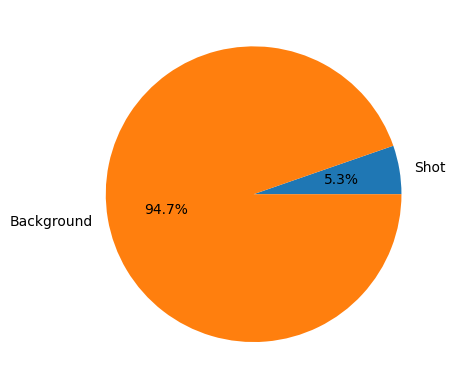

In [25]:
labels = 'Shot', 'Background'
shot_percent = shot_cant / (shot_cant + back_cant)
back_percent = back_cant / (shot_cant + back_cant)

fig, ax = plt.subplots()
_, _, _ = ax.pie((shot_percent, back_percent), labels=labels, autopct='%1.1f%%')

## Choose random audio

In [28]:
shot_name = DATASET['audio_name'][DATASET['labels'] == 1].sample().values[0]
back_name = DATASET['audio_name'][DATASET['labels'] == 0].sample().values[0]

shot_sound, shot_sr = librosa.load(shot_name, sr=SAMPLE_RATE)
back_sound, back_sr = librosa.load(back_name, sr=SAMPLE_RATE)

## Basic information regarding audios

In [36]:
shot_sound.shape

(32000,)

In [37]:
# duration of 1 sample (shoot or background)
duration_sample = 1 / back_sr
print(f"Duration of 1 sample is: {duration_sample:.6f} seconds")

Duration of 1 sample is: 0.000125 seconds


In [38]:
back_sr

8000

In [39]:
# total number of samples in audio file
tot_samples = len(back_sound)
tot_samples

32000

In [40]:
# duration of the audio signal in seconds
duration = duration_sample * len(back_sound)
print(f"Duration of signal is: {duration:.2f} seconds")

Duration of signal is: 4.00 seconds


## Listen audios

In [41]:
ipd.Audio(shot_sound, rate=shot_sr)

In [42]:
ipd.Audio(back_sound, rate=back_sr)

## Visualize graphs

### Frequency domain

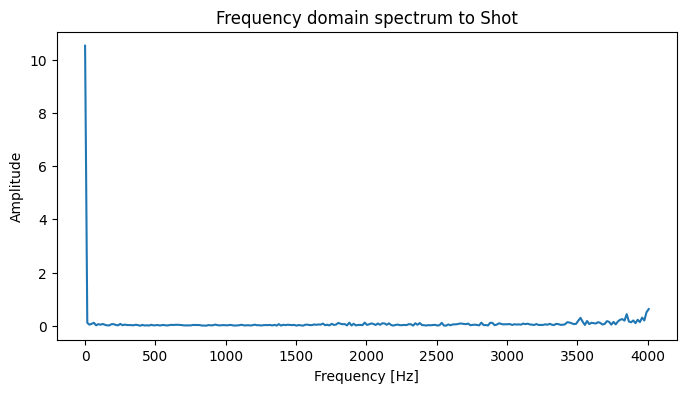

In [43]:
# SHOT
plot_fft(shot_sound, shot_sr, audio_type='Shot')

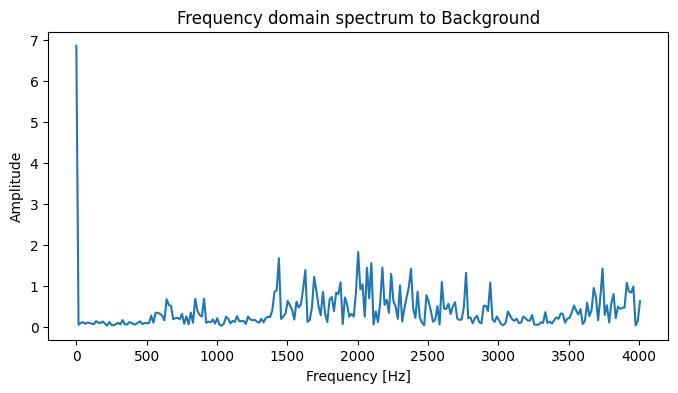

In [44]:
# BACKGROUND
plot_fft(back_sound, back_sr, audio_type='Background')

### Spectrogram

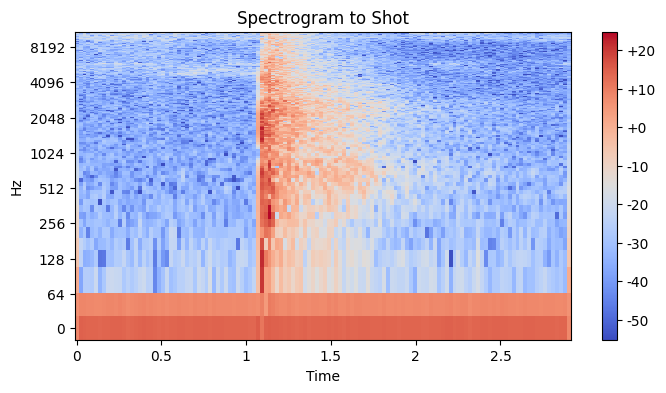

In [45]:
# SHOT
plot_spectrogram(shot_sound, y_axis='log', audio_type='Shot')

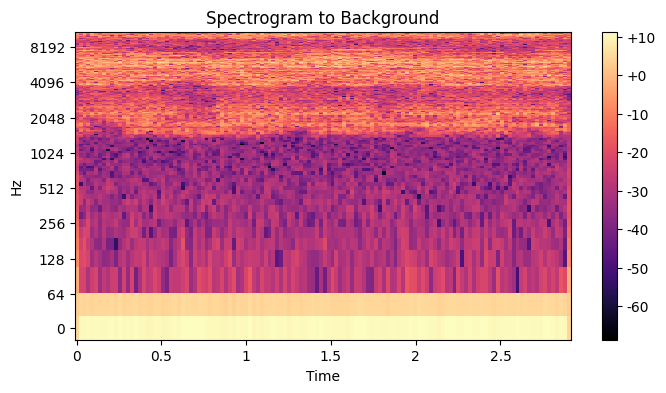

In [46]:
# BACKGROUND
plot_spectrogram(back_sound, y_axis='log', audio_type='Background')

### Mel spectrogram

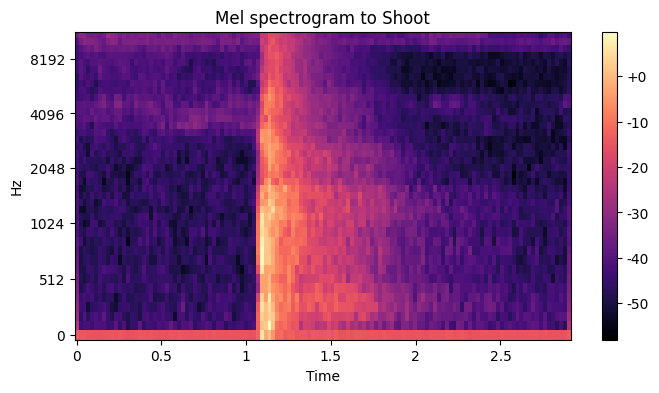

In [47]:
# SHOT
plot_mel_spectrogram(shot_sound, shot_sr, audio_type='Shoot')

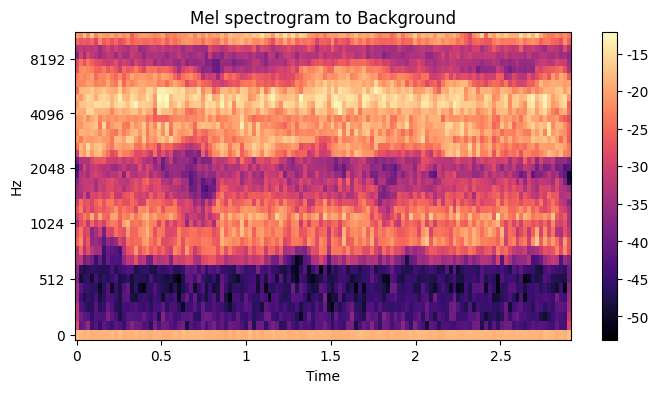

In [48]:
# BACKGROUND
plot_mel_spectrogram(back_sound, back_sr, audio_type='Background')

### Mel-Frequency Cepstral

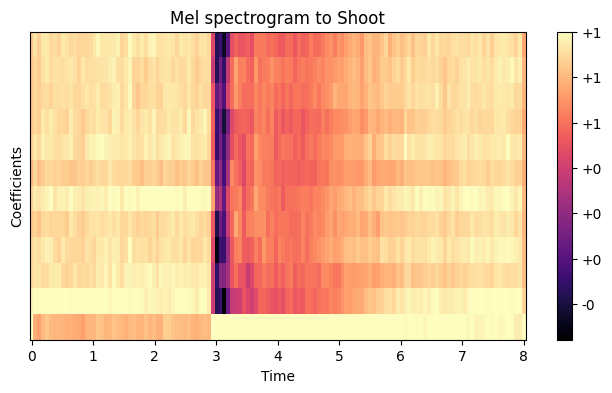

In [49]:
# SHOT
plot_mfcc(shot_sound, shot_sr, 'Shoot')

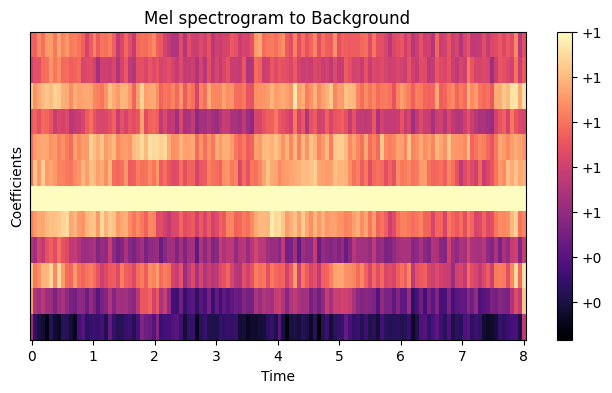

In [51]:
# BACKGROUND
plot_mfcc(back_sound, back_sr, 'Background')

## Spectral Centroids

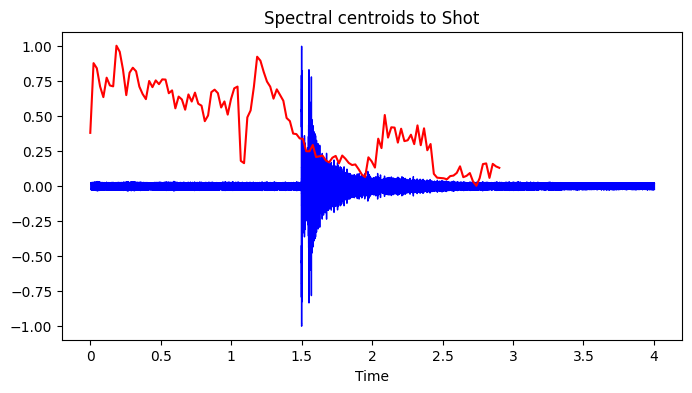

In [52]:
# SHOT
plot_spectral_centroid(shot_sound, shot_sr, 'Shot')

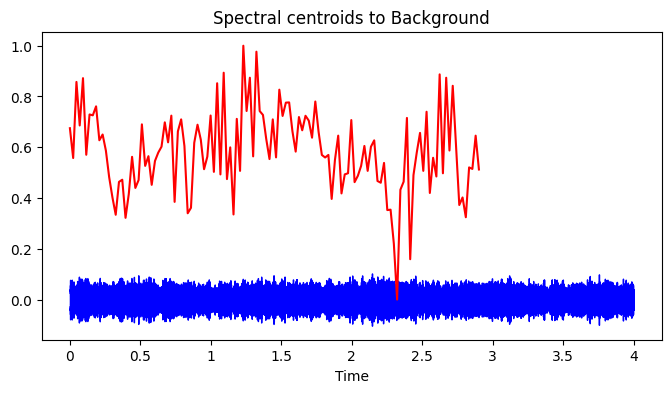

In [53]:
# BACKGROUND
plot_spectral_centroid(back_sound, back_sr, 'Background')

# Prepare Data to Train and Val

### Train

In [54]:
shot_dir = DATASET['audio_name'][DATASET['labels'] == 1].values
shot_label = DATASET['labels'][DATASET['labels'] == 1].values

back_dir = DATASET['audio_name'][DATASET['labels'] == 0].values[:600]
back_label = DATASET['labels'][DATASET['labels'] == 0].values[:600]

shot_signals =[librosa.load(shot_name, sr=SAMPLE_RATE) for shot_name in shot_dir]
back_signals = [librosa.load(back_name, sr=SAMPLE_RATE) for back_name in back_dir]

In [55]:
shot_mfcc = np.array([extract_mfccs(shot, sr).T for shot, sr in shot_signals])
back_mfcc = np.array([extract_mfccs(back, sr).T for back, sr in back_signals])

In [56]:
X = np.concatenate((shot_mfcc, back_mfcc))
y = np.concatenate((shot_label, back_label))

In [57]:
# create train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)
# X_train = X_train[..., np.newaxis]
# X_test = X_test[..., np.newaxis]

### Val

In [61]:
shot_dir = VAL_DATASET['audio_name'][VAL_DATASET['labels'] == 1].values
shot_label = VAL_DATASET['labels'][VAL_DATASET['labels'] == 1].values

back_dir = VAL_DATASET['audio_name'][VAL_DATASET['labels'] == 0].values[:600]
back_label = VAL_DATASET['labels'][VAL_DATASET['labels'] == 0].values[:600]

shot_signals =[librosa.load(shot_name, sr=SAMPLE_RATE) for shot_name in shot_dir]
back_signals = [librosa.load(back_name, sr=SAMPLE_RATE) for back_name in back_dir]

In [62]:
shot_mfcc = np.array([extract_mfccs(shot, sr).T for shot, sr in shot_signals])
back_mfcc = np.array([extract_mfccs(back, sr).T for back, sr in back_signals])

In [63]:
X = np.concatenate((shot_mfcc, back_mfcc))
y = np.concatenate((shot_label, back_label))

In [64]:
X_val1, X_val2, y_val1, y_val2 = train_test_split(X, y, test_size=0.25, shuffle=True)

### Info

In [80]:
print(f"Train shape: {X_train.shape}")

Train shape: (897, 126, 12)


In [59]:
print(f"Test shape: {X_test.shape}")

Test shape: (300, 126, 12)


In [65]:
print(f"1. Validation shape: {X_val1.shape}")

Validation shape: (562, 126, 12)


In [67]:
print(f"2. Validation shape: {X_val2.shape}")

2. Validation shape: (188, 126, 12)


# Implementing a Neural Network

## Plot History

In [68]:
def plot_history(history):
    """
        Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

## Prediction function

In [95]:
def predict(model, X, y):
  """Predict a single sample using the trained model

  :param model: Trained classifier
  :param X: Input data
  :param y (int): Target
  """

  # add a dimension to input data for sample - model.predict() expects a 4d array in this case
  # X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

  # perform prediction
  prediction = model.predict(X)

  # get index with max value
  predicted_index = np.argmax(prediction, axis=1)

  print("Target: {}, Predicted label: {}".format(y, predicted_index))

## Only dense

In [ ]:
model = keras.Sequential([
        # input layer
        keras.layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])),

        # 1st hidden layer
        keras.layers.Dense(512, activation="relu"),

        # 2nd hidden layer
        keras.layers.Dense(256, activation="relu"),

        # 3rd hidden layer
        keras.layers.Dense(64, activation="relu"),

        # output layer
        keras.layers.Dense(2, activation="softmax")
        ])

## Convolutional Network

In [ ]:
def build_model(input_shape):

  """Generates CNN model

  :param input_shape (tuple): Shape of input set
  :return model: CNN model
  """

  # create model
  model = keras.Sequential()

  # 1st conv layer
  model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
  model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
  model.add(keras.layers.BatchNormalization())

  # 2nd conv layer
  model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
  model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
  model.add(keras.layers.BatchNormalization())

  # 3rd conv layer
  model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
  model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
  model.add(keras.layers.BatchNormalization())

  # flatten output and feed it into dense layer
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(64, activation='relu'))
  model.add(keras.layers.Dropout(0.3))

  # output layer
  model.add(keras.layers.Dense(2, activation='softmax'))

  return model


In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

In [ ]:
input_shape

(126, 13, 1)

## LSTM

In [74]:
def build_model(input_shape):
    """Generates RNN-LSTM model

    :param input_shape (tuple): Shape of input set
    :return model: RNN-LSTM model
    """

    # build network topology
    model = keras.Sequential()

    # 2 LSTM layers
    model.add(keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(64))

    # dense layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(2, activation='softmax'))

    return model

In [75]:
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_model(input_shape)

In [76]:
print(f"Input shape of LSTM: {input_shape}")

Input shape of LSTM: (126, 12)


## Compile network

In [77]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [78]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 126, 64)           19712     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 57026 (222.76 KB)
Trainable params: 57026 (222.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [81]:
# train model
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=30, callbacks=[callback])

Epoch 1/30
29/29 [==============================] - 6s 194ms/step - loss: 0.6923 - accuracy: 0.5217 - val_loss: 0.6906 - val_accuracy: 0.4967
Epoch 2/30
29/29 [==============================] - 4s 139ms/step - loss: 0.6907 - accuracy: 0.5217 - val_loss: 0.6905 - val_accuracy: 0.4933
Epoch 3/30
29/29 [==============================] - 4s 128ms/step - loss: 0.6914 - accuracy: 0.5139 - val_loss: 0.6885 - val_accuracy: 0.6633
Epoch 4/30
29/29 [==============================] - 5s 188ms/step - loss: 0.6917 - accuracy: 0.5184 - val_loss: 0.6887 - val_accuracy: 0.5333
Epoch 5/30
29/29 [==============================] - 5s 165ms/step - loss: 0.6875 - accuracy: 0.5530 - val_loss: 0.6863 - val_accuracy: 0.5133
Epoch 6/30
29/29 [==============================] - 4s 128ms/step - loss: 0.6880 - accuracy: 0.5429 - val_loss: 0.6863 - val_accuracy: 0.5667
Epoch 7/30
29/29 [==============================] - 4s 139ms/step - loss: 0.6895 - accuracy: 0.5173 - val_loss: 0.6869 - val_accuracy: 0.5033
Epoch 

## Evaluate model on val set

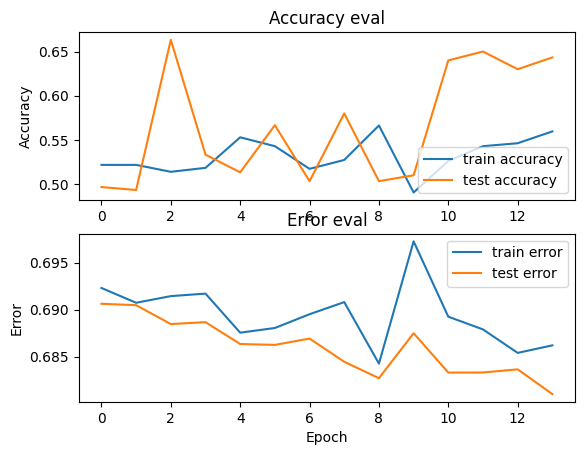

In [82]:
plot_history(history)

In [83]:
# evaluate model on val set
val_loss, val_acc = model.evaluate(X_val1, y_val1, verbose=2)

print('\nVal accuracy:', val_acc)

18/18 - 1s - loss: 0.6834 - accuracy: 0.5747 - 657ms/epoch - 36ms/step

Val accuracy: 0.5747330784797668


In [84]:
shoot_index = [i for i, e in enumerate(y_val2) if e == 1]

X_shoot = X_val2[shoot_index[:]]
y_shoot = y_val2[shoot_index[:]]

In [85]:
# evaluate model on val set only shoots
val_loss, val_acc = model.evaluate(X_shoot, y_shoot, verbose=2)
print('\nTest accuracy:', val_acc)

1/1 - 0s - loss: 0.6711 - accuracy: 0.7500 - 141ms/epoch - 141ms/step

Test accuracy: 0.75


In [88]:
# pick a sample to predict from the test set
X_to_predict = X_val2[12]
y_to_predict = y_val2[12]

# predict sample
predict(model, X_to_predict, y_to_predict)

1/1 [==============================] - 0s 158ms/step
Target: 1, Predicted label: [1]


## Save model

In [ ]:
model.save("CNN_MODEL_REDUCED.keras")

## Load model

In [ ]:
model = keras.models.load_model("CNN_MODEL_4s.keras")

# Load complete sound to infer

In [90]:
FOLDER_PATH = './lotes_procesar'
AUDIO_NAME = 'BO-07_OBBA-20_20191019_062000 .mp3'

SEGMENT_DURATION = 4 # measured in second

In [91]:
def extract_segments(signal, samples_per_segment, num_segments):

  segments = []

  for s in range(num_segments):
    start = s * samples_per_segment
    finish = start + samples_per_segment

    segment = signal[start:finish]

    segments.append(segment)

  return np.array(segments)

In [98]:
def infer(audio_name):

  mfcc = []

  # load audio
  audio_path = os.path.join(FOLDER_PATH, audio_name)
  signal, sr = librosa.load(audio_path, sr=SAMPLE_RATE)

  print(f"Frecuencia de muestreo: {sr} Hz")

  # extract audio duration
  duration = len(signal)//sr

  print(f"Duracion {duration} seconds")

  # resize audio
  signal = signal[:duration*sr]

  # get number of SEGMENT_DURATION second segments
  num_segments = duration//SEGMENT_DURATION

  print(f"Numero de segmentos: {num_segments}")

  # get samples per segments
  samples_per_segments = SEGMENT_DURATION * sr

  print(f"Muestras por cada segmento: {samples_per_segments}\n")

  # extract SEGMENT_DURATION segments
  segments = extract_segments(signal, samples_per_segments, num_segments)

  # extract mfcc for each segment
  mfcc = np.array([extract_mfccs(seg, sr).T for seg in segments])

  # resize input to infer
  # X = mfcc[..., np.newaxis]

  # infer
  prediction = model.predict(mfcc)

  index = np.argmax(prediction,  axis=1)

  for i in range(len(index)):
    if index[i] == 1:
        inicio_segundos = SEGMENT_DURATION * i
        fin_segundos = inicio_segundos + SEGMENT_DURATION

        # Convertir a minutos si supera los 60 segundos
        if fin_segundos > 60:
            inicio_minutos = inicio_segundos // 60
            inicio_segundos = inicio_segundos % 60
            fin_minutos = fin_segundos // 60
            fin_segundos = fin_segundos % 60

            print("Shot between: {}:{} and {}:{} minutes".format(inicio_minutos, inicio_segundos, fin_minutos, fin_segundos))
        else:
            print("Shot between: {} and {} seconds".format(inicio_segundos, fin_segundos))

In [99]:
infer(AUDIO_NAME)

Frecuencia de muestreo: 8000 Hz
Duracion 600 seconds
Numero de segmentos: 150
Muestras por cada segmento: 32000

5/5 [==============================] - 0s 55ms/step
Shot between: 0 and 4 seconds
Shot between: 4 and 8 seconds
Shot between: 8 and 12 seconds
Shot between: 12 and 16 seconds
Shot between: 16 and 20 seconds
Shot between: 20 and 24 seconds
Shot between: 24 and 28 seconds
Shot between: 28 and 32 seconds
Shot between: 32 and 36 seconds
Shot between: 36 and 40 seconds
Shot between: 40 and 44 seconds
Shot between: 44 and 48 seconds
Shot between: 48 and 52 seconds
Shot between: 52 and 56 seconds
Shot between: 56 and 60 seconds
Shot between: 1:0 and 1:4 minutes
Shot between: 1:4 and 1:8 minutes
Shot between: 1:8 and 1:12 minutes
Shot between: 1:12 and 1:16 minutes
Shot between: 1:16 and 1:20 minutes
Shot between: 1:20 and 1:24 minutes
Shot between: 1:24 and 1:28 minutes
Shot between: 1:28 and 1:32 minutes
Shot between: 1:32 and 1:36 minutes
Shot between: 1:36 and 1:40 minutes
Shot 